# Initialize notebook

In [1]:
import wandb

In [2]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary
from utils.train_utils.model_utils import Conv2dBlock, GatedConv2dBlock, GatedUpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


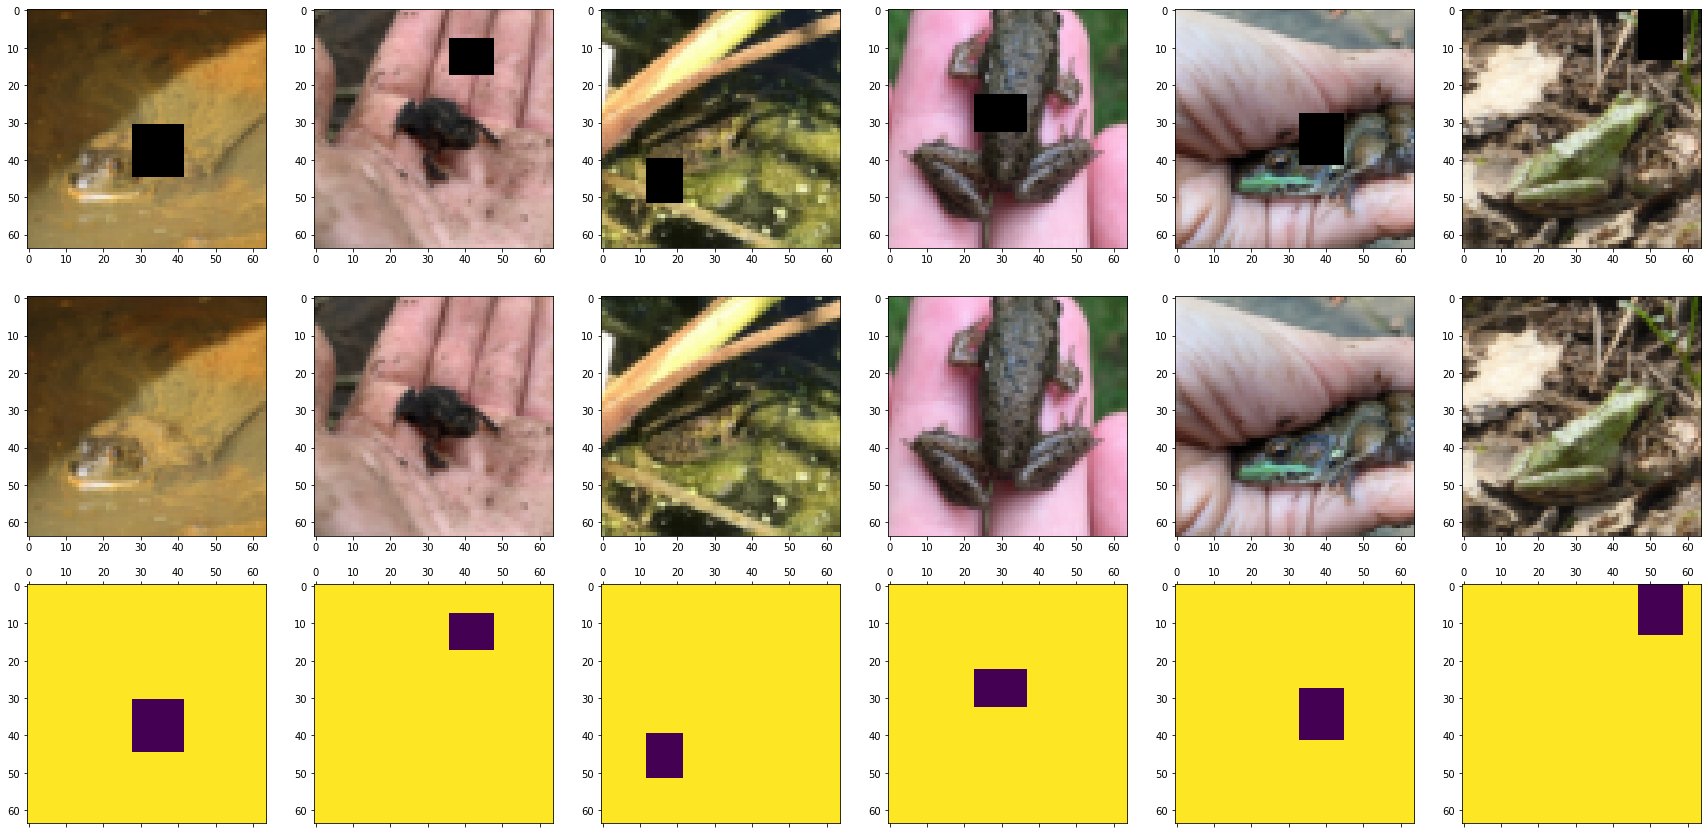

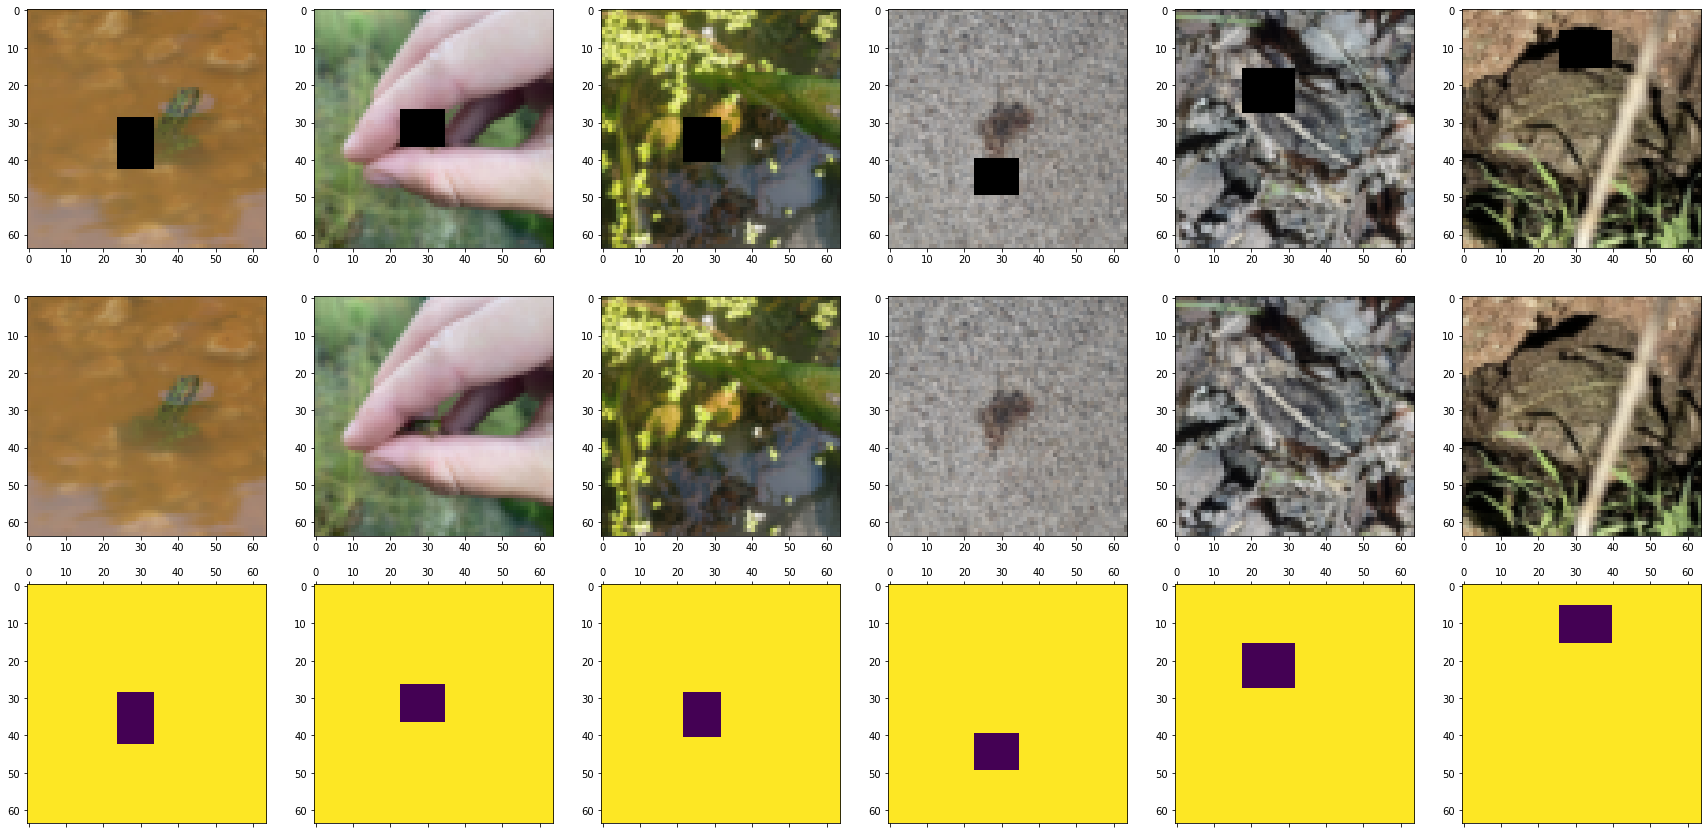

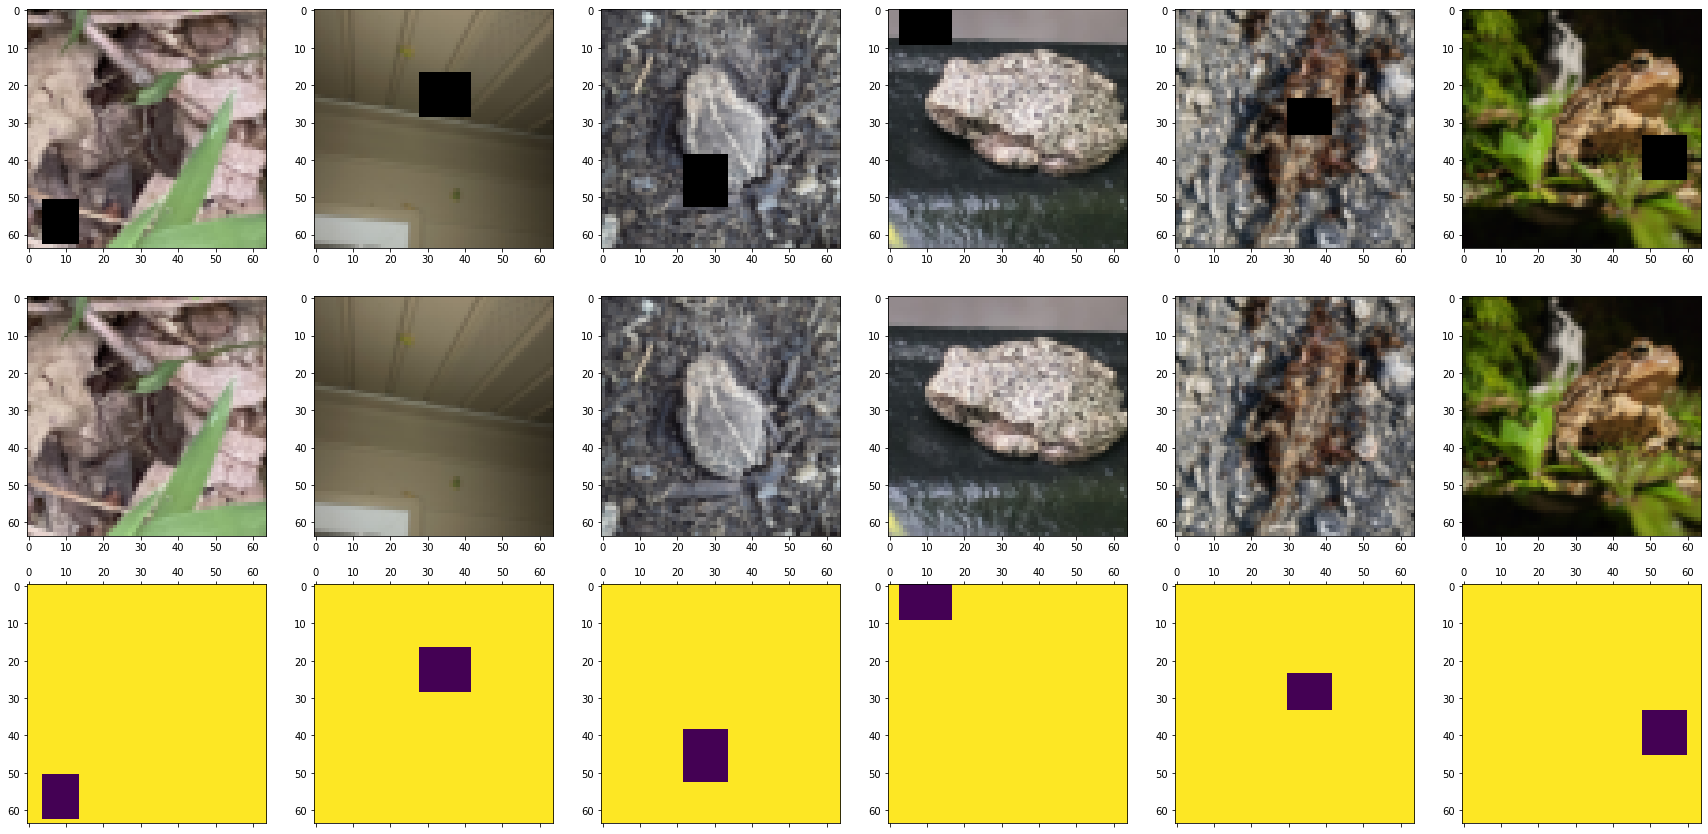

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6)
sample_batch(valid_dataset, sample_size = 6)
sample_batch(test_dataset, sample_size = 6)


# Introduction
This notebook aims to explore a basic GAN model.

# Model experiment


In [6]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(Generator, self).__init__()
        
        # same -> down -> same -> down
        self.conv0 = GatedConv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 2 x same
        self.conv4 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # 4 x dilated conv
        self.conv6 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)
        self.conv7 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 4, dilation = 4, activation = activation)
        self.conv8 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 8, dilation = 8, activation = activation)
        self.conv9 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 16, dilation = 16, activation = activation)

        # 2 x same
        self.conv10 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = GatedUpConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation, scale_factor = (2,2))
        self.conv13 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = GatedUpConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation, scale_factor = (2,2))
        self.conv15 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, output_dim, kernel_size = 3, stride = 1, padding = 'same')

    def forward(self, input_tensor):

        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # middle layers
        x = self.conv4(x) + x
        x = self.conv5(x) + x
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x
        x = self.conv10(x) + x
        x = self.conv11(x) + x

        # up sample
        x = self.conv12(x)
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        x = self.final(x)

        return x


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # linear to predict classes
        self.final = nn.Conv2d(hidden_dim, 1, kernel_size = 3, stride = 1, padding = 'same')

    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x) + x
        x = self.conv2(x) + x
        x = self.conv3(x) + x
        x = self.conv4(x) + x

        # scores
        x = self.final(x)
        x = torch.sigmoid(x)

        return x


# Training configuration

In [7]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model, but with partial convolutions.
        Discriminator outputs 1 channel map, which is matched against the mask. 
        """,
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/PatchGAN/experiment_maskedpatchloss/generator/generator",
    "discriminator" : "/home/e/e0425222/CS4243-project/active_experiments/PatchGAN/experiment_maskedpatchloss/discriminator/discriminator"
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-4,
    "alpha": 0.1,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [8]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], output_dim = 3, activation = MODEL_PARAMS["activation"])
discriminator = Discriminator(input_dim = 3, hidden_dim = MODEL_PARAMS["hidden_dim"], activation = MODEL_PARAMS["activation"])

summary(generator)
summary(discriminator)

# 2. device
parallel = True
device = 'cuda:1'  
devices = [1,2,3,0]

if not parallel:
    generator1 = generator.to(device)
    discriminator = discriminator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()
discriminator_loss_function = lambda img, gt, mask : (nn.functional.binary_cross_entropy(img, gt, reduction = 'none') * (1-mask)).sum()/(1-mask).sum()

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}


# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["discriminator_model"] = discriminator
TRAINING_PARAMS["discriminator_optimizer"] = discriminator_optimizer
TRAINING_PARAMS["discriminator_scheduler"] = discriminator_scheduler
TRAINING_PARAMS["discriminator_loss_function"] = discriminator_loss_function
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function



model has 1.116355 million parameters
model has 0.150721 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [9]:
wandb.init(project="PatchGAN", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanyjnaaman (use `wandb login --relogin` to force relogin)


[]

# Train

## Train functions

In [10]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]

    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]
    ALPHA = training_params["alpha"]

    # models
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator"] = 0.0
    running_results["loss_generator_r"] = 0.0
    running_results["loss_generator_adv"] = 0.0

    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # set the gradients to zeros
            GENERATOR_OPTIMIZER.zero_grad()
            DISCRIMINATOR_OPTIMIZER.zero_grad()

            # reshape to channel first
            _, h, w, _ = input_batched.shape
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # ===== FORWARD PASS =====

            # 1. train discriminator
            
            # 1.1 generate images
            input_batched.requires_grad_()
            output_batched = generator(input_batched)

            # 1.2 splice with ground truth
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 1.3 feed into discriminator
            label_real = torch.ones(BATCH_SIZE, 1, h, w).to(device)
            label_fake = mask_batched

            pred_real = discriminator(ground_truth_batched)
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real, mask_batched)

            pred_fake = discriminator(spliced_batched)
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake, mask_batched)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 2. train generator (reconstruction, adverserial)
            # 2.1 forward pass by generator to produce images, splice them
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2.2 reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 2.3 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1, h, w).to(device)
            pred_adverserial = discriminator(spliced_batched)
            loss_g_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred_adverserial, label_real, mask_batched) # want it to classify all as real

            # 2.5 backprop
            loss_g = loss_g_reconstruction + ALPHA * loss_g_adverserial
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator"] += loss_g.detach().item()
            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()
            running_results["loss_generator_adv"] += loss_g_adverserial.detach().item()
            running_results["loss_discriminator"] += loss_d.detach().item()

            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")

                # adverserial predictions
                batched_adv_predictions = torch.cat([
                    mask_batched[:SAMPLE_SIZE],
                    pred_adverserial[:SAMPLE_SIZE]
                ], dim = 0)
                
                adv_array = torchvision.utils.make_grid(batched_adv_predictions, nrow = SAMPLE_SIZE, padding = 50)
                adv_images = wandb.Image(
                    adv_array, 
                    caption = "1st row: Mask, 2nd row: Predicted segmentation")
                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "adverserial images" : adv_images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del loss_d
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [11]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)

            # 2. predict    
            output_batched = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [12]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_discriminator"] = []
    train_results["loss_generator"] = []
    train_results["loss_generator_r"] = []
    train_results["loss_generator_adv"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Train

In [13]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 29.46507789857926   L2 loss (Whole): 0.0014843441771283264   L2 loss (Mask): 0.12884973417366705   L1 loss (Whole): 0.005137406379705475   L1 loss (Mask): 0.44647548333291087   LPIPS (Whole): 0.05447872384421287   loss_discriminator: 0.13184281284770658   loss_generator: 0.2288985739792547   loss_generator_r: 0.12884973417366705   loss_generator_adv: 1.0004883804628926    
15/15: Peak SnR (Whole): 31.035254033406577   L2 loss (Whole): 0.0007883467207041879   L2 loss (Mask): 0.06848300819595655   L1 loss (Whole): 0.004017099055151145   L1 loss (Mask): 0.3491882741451263   LPIPS (Whole): 0.045228947699069974    
Completed epoch 1! Took 5.953786385059357 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 31.024548918201077   L2 loss (Whole): 0.0007913245323805079   L2 loss (Mask): 0.06852670593127128   L1 loss (Whole): 0.0040481443561974076   L1 loss (Mask): 0.3505249498351928   LPIPS (Whole): 0.04554132783124524   loss_di

({'Peak SnR (Whole)': [29.471149285634358,
   31.029230521275448,
   31.34796059437287,
   31.35226268034715,
   31.56964718989837,
   31.90077829360962,
   32.26994233253674,
   32.31211811456925,
   32.416651921394546,
   32.429252832363815,
   32.448540944319504,
   32.54573581157587,
   32.5272043179243,
   32.74160256752601,
   32.61704364189735,
   32.80398311370458,
   32.8528835834601,
   32.76839675658788,
   32.95647452427791,
   32.876392144423264],
  'L2 loss (Whole)': [0.0014806589535556925,
   0.0007905313824990001,
   0.0007351132483633521,
   0.0007339908464555031,
   0.0006986353893388206,
   0.0006470526883883091,
   0.0005940647216704794,
   0.0005888181650124562,
   0.0005742976824806717,
   0.0005715050591299167,
   0.0005706579341233756,
   0.0005573352954786223,
   0.0005596771378082056,
   0.0005326404057902833,
   0.000548924936783106,
   0.0005254655093617308,
   0.0005191231789350964,
   0.0005295959251667134,
   0.0005072158912811667,
   0.000516094229309461

In [14]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
155/156: Peak SnR (Whole): 32.929804488151305   L2 loss (Whole): 0.0005102336626394742   L2 loss (Mask): 0.044177915756740876   L1 loss (Whole): 0.003107183564814829   L1 loss (Mask): 0.2690414881513965   LPIPS (Whole): 0.024806432654300044   loss_discriminator: 0.10605311840772629   loss_generator: 0.15107131725357426   loss_generator_r: 0.044177915756740876   loss_generator_adv: 1.0689339999229677    
15/15: Peak SnR (Whole): 32.81875343322754   L2 loss (Whole): 0.0005235832999460399   L2 loss (Mask): 0.0453659916917483   L1 loss (Whole): 0.0031230583786964416   L1 loss (Mask): 0.270660791794459   LPIPS (Whole): 0.02432241414984067        
Completed epoch 21! Took 2.6930922587712605 min
Saved models!

===== Epoch: 22 ===== 
155/156: Peak SnR (Whole): 32.981629623905306   L2 loss (Whole): 0.000503698660947022   L2 loss (Mask): 0.043809579192630704   L1 loss (Whole): 0.003076125995346135   L1 loss (Mask): 0.26754777335351515   LPIPS (Whole): 0.02443017078743827 

wandb: Network error (ReadTimeout), entering retry loop.


60/156: Peak SnR (Whole): 32.9558928489685   L2 loss (Whole): 0.0005069364682033969   L2 loss (Mask): 0.04408720855911573   L1 loss (Whole): 0.0030792138810890415   L1 loss (Mask): 0.26785303428769114   LPIPS (Whole): 0.023970140113184848   loss_discriminator: 0.1063812385002772   loss_generator: 0.1502101567884286   loss_generator_r: 0.04408720855911573   loss_generator_adv: 1.0612294733524323      

wandb: Network error (ReadTimeout), entering retry loop.


155/156: Peak SnR (Whole): 32.95641602546938   L2 loss (Whole): 0.000507195940008387   L2 loss (Mask): 0.04407009042559132   L1 loss (Whole): 0.0030796823211975636   L1 loss (Mask): 0.26765025584928454   LPIPS (Whole): 0.0240021116430721   loss_discriminator: 0.10656266385509122   loss_generator: 0.15008516378941075   loss_generator_r: 0.04407009042559132   loss_generator_adv: 1.0601507240726102         
15/15: Peak SnR (Whole): 33.01241887410482   L2 loss (Whole): 0.0005007866052134584   L2 loss (Mask): 0.043577298521995544   L1 loss (Whole): 0.003028852849577864   L1 loss (Mask): 0.26365460952123004   LPIPS (Whole): 0.023197107513745627   
Completed epoch 35! Took 3.165697928269704 min
Saved models!

===== Epoch: 36 ===== 
155/156: Peak SnR (Whole): 32.95694251521941   L2 loss (Whole): 0.0005069148426334704   L2 loss (Mask): 0.04378857425143642   L1 loss (Whole): 0.003089758059791019   L1 loss (Mask): 0.2669524505253761   LPIPS (Whole): 0.024082335469222838   loss_discriminator: 0.10

({'Peak SnR (Whole)': [32.93614594141642,
   32.98460393074231,
   32.91917425546891,
   32.916993581331695,
   32.99191207152147,
   32.979081973051414,
   32.959340865795426,
   32.95560888143686,
   32.939581687633805,
   32.93168015357776,
   32.981276059762024,
   32.90635101611797,
   32.91407361397376,
   32.958349325718025,
   32.956025808285446,
   32.9589703755501,
   32.97956312619723,
   33.03489321928758,
   32.94507619662163,
   32.97579711522811],
  'L2 loss (Whole)': [0.0005095425509259654,
   0.0005033692564794387,
   0.0005114066900718265,
   0.0005113534110326631,
   0.0005026653148562241,
   0.0005044478908903563,
   0.0005063752196759033,
   0.0005072317521225136,
   0.00050877788583957,
   0.0005111071752766386,
   0.000503819546093627,
   0.0005130199258415721,
   0.0005114532242982816,
   0.0005066124254088395,
   0.0005072356331929301,
   0.0005066821861710662,
   0.0005038430229969657,
   0.0004977904021731005,
   0.000508174209337598,
   0.0005048932554274917

In [15]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)

wandb: Network error (ReadTimeout), entering retry loop.
